<h2>Module 2 (Fashion Objects localiztion)</h2>

this module use object detection techniques to localizalize fashion objects in the images, notebook is edited on kaggle

Mask R-CNN with COCO pretrained weights to the task of [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6).

In [ ]:
#importing library 
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [ ]:

DATA_DIR = Path('/kaggle/input')
ROOT_DIR = Path('/kaggle/working')

# the classification ignores attributes (only categories),and the image size is set to 512
NUM_CATS = 46
IMAGE_SIZE = 512

# Dowload Libraries and Pretrained Weights

In [ ]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 39.26 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

coco_weight = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


# Set Config

Mask R-CNN has a load of hyperparameters. I only adjust some of them.

In [ ]:
class FashionConfiguration(Config):
    name = "fashion"
    num_classes = NUM_CATS + 1 # +1 for the background class
    
    gpu = 1
    images_per_gpu = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    AlGO_BACKBONE = 'resnet50'
    
    MIN_DIM = IMAGE_SIZE
    MAX_DIM = IMAGE_SIZE    
    RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, set them so that this kernel can be run in 9 hours
    steps_per_epoch = 1000
    validation_steps = 200
    
config = FashionConfiguration()
config.display()

# Make Datasets

In [ ]:
with open(DATA_DIR/'imaterialist-fashion-2019-FGVC6/label_descriptions.json') as f:
    label_descriptions = json.load(f)

labeled_names = [x['name'] for x in label_descriptions['categories']]

In [ ]:
segment_df = pd.read_csv(DATA_DIR/'imaterialist-fashion-2019-FGVC6/train.csv')

multilabeled_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabeled_percent:.2f}%")

Segments that have attributes: 3.47%


Segments that contain attributes are only 3.46% of data, and [according to the host](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/90643#523135), 80% of images have no attribute. So, in the first step, we can only deal with categories to reduce the complexity of the task.

In [ ]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


Rows with the same image are grouped together because the subsequent operations perform in an image level.

In [ ]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45195


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


Here is the custom function that resizes an image.

In [ ]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

The crucial part is to create a dataset for this task.

In [ ]:
class CreateFashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'imaterialist-fashion-2019-FGVC6/train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

Let's visualize some random images and their masks.

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/e7cfc57f357615b5c80074331c50eafc.jpg', ['top, t-shirt, sweatshirt', 'skirt', 'shoe', 'shoe'])


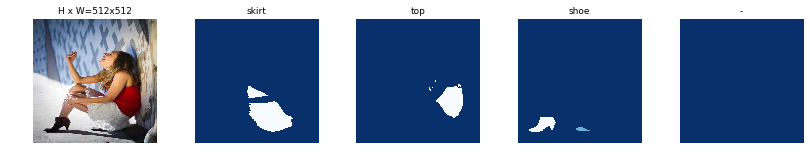

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/6b2431fc30a0bb886b83d12e737a9cb3.jpg', ['dress', 'neckline'])


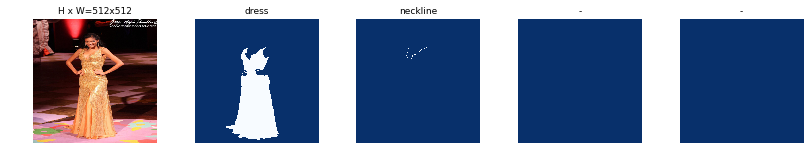

('/kaggle/input/imaterialist-fashion-2019-FGVC6/train/83298db53ba59bed18f42f3ef68c5e29.jpg', ['collar', 'pocket', 'pocket', 'sleeve', 'sleeve', 'pocket', 'pocket', 'jacket'])


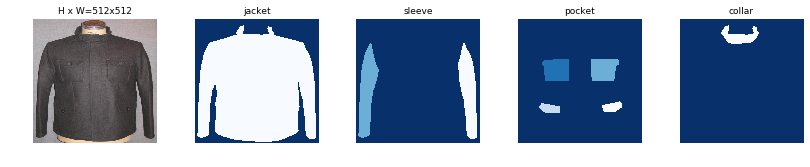

In [ ]:
dataset = CreateFashionDataset(image_df)
dataset.prepare()

for i in range(3):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Now, the data are partitioned into train and validation sets.

In [ ]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 3

kfold = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kfold.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = CreateFashionDataset(train_df)
train_dataset.prepare()

valid_dataset = CreateFashionDataset(valid_df)
valid_dataset.prepare()

Let's visualize class distributions of the train and validation data.

Total train images:  30130
Total train segments:  220438


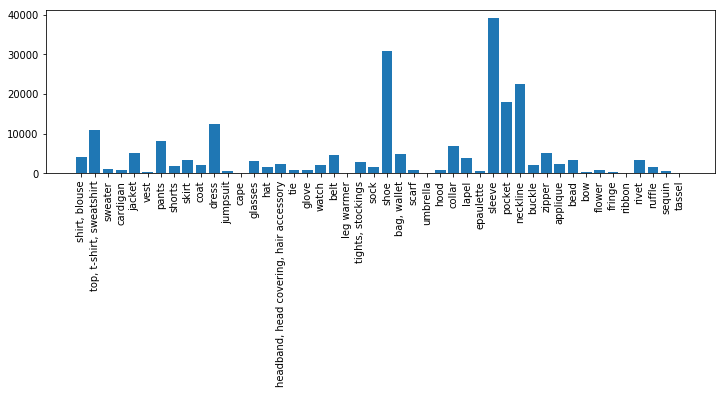

Total train images:  15065
Total validation segments:  110775


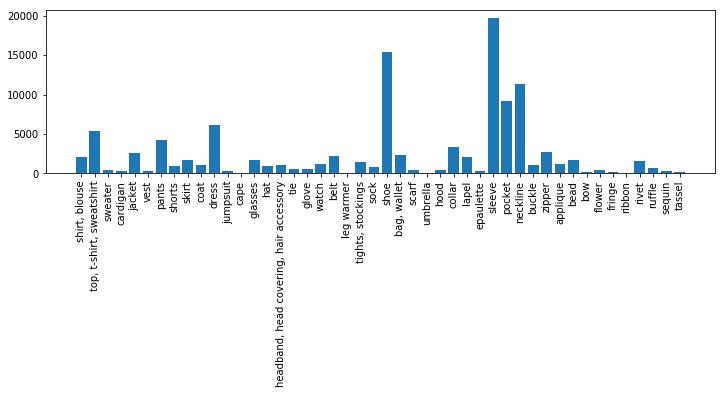

In [ ]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total train images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

# Train

In [ ]:
# Note that any hyperparameters here, such as LR, may still not be optimal
Learning_Rate = 1e-4
EPOCHS = [2, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

This section creates a Mask R-CNN model and specifies augmentations to be used.

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(coco_weight, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

First, we train only the heads.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=Learning_Rate*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /kaggle/working/fashion20210302T1327/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

Then, all layers are trained.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=Learning_Rate,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.0001

Checkpoint Path: /kaggle/working/fashion20210302T1327/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b     

Afterwards, we reduce LR and train again.

In [ ]:
%%time

model.train(train_dataset, valid_dataset,
            learning_rate=Learning_Rate/5,
            epochs=EPOCHS[2],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 6. LR=2e-05

Checkpoint Path: /kaggle/working/fashion20210302T1327/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

Let's visualize training history and choose the best epoch.

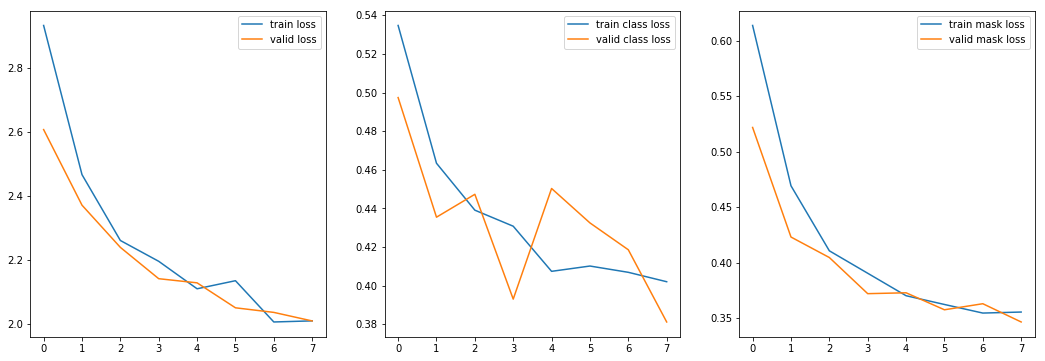

In [ ]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  8
Valid loss:  2.0093588030338285


# Predict

The final step is to use our model to predict test data.

In [ ]:
glob_list_models = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
models_path = glob_list_models[0] if glob_list_models else ''

This cell defines InferenceConfig and loads the best trained model.

In [ ]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert models_path != '', "Provide path to trained weights"
print("Loading weights from ", models_path)
model.load_weights(models_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/working/fashion20210302T1327/mask_rcnn_fashion_0008.h5
Re-starting from epoch 8


In [ ]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [ ]:
li =['image_33_6.jpg','image_467_4.jpg']

In [ ]:
with open(DATA_DIR/'imaterialist-fashion-2019-FGVC6/label_descriptions.json') as f:
    labels_descriptions = json.load(f)

labels_names = [x['name'] for x in labels_descriptions['categories']]

In [ ]:
li = ['image_33_6.jpg','image_467_4.jpg']

image_33_6.jpg


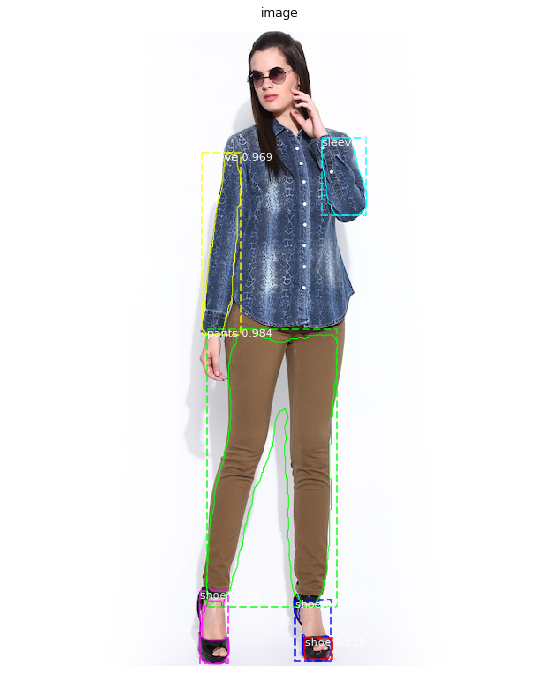

image_467_4.jpg


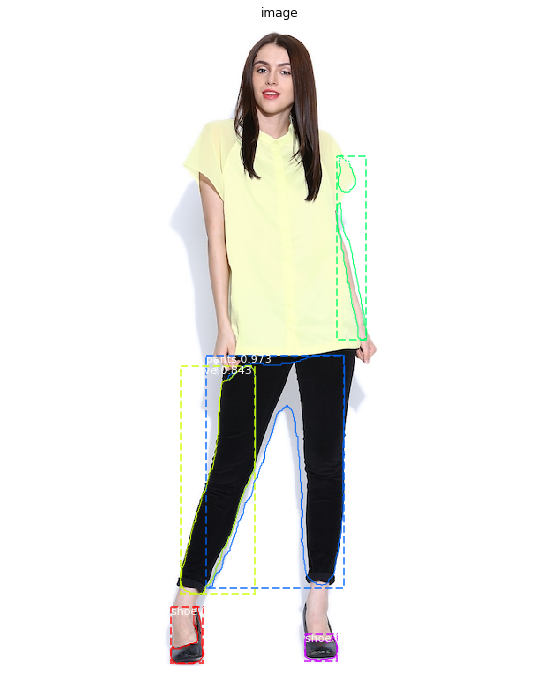

In [ ]:

for i in li:
    print(i)
    image_id = 'image'
    image_path = str(DATA_DIR/'test-data'/i)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    results = model.detect([resize_image(image_path)])
    result = results[0]
    
    if result['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(result['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, result['class_ids'], 
                                ['bg']+labels_names, result['scores'],
                                title=image_id, figsize=(12, 12),show_mask=False)

In [ ]:
#combine categories for simplification
feet = ['shoe']
upperbody = ['cardigan',
 'collar',
 'epaulette',
 'hood',
 'jacket',
 'lapel',
 'neckline',
 'shirt, blouse',
 'sleeve',
 'sweater',
 'top, t-shirt, sweatshirt',
 'vest']

lowerbody = ['pants', 'pocket', 'shorts', 'skirt']
wholebody = ['cape', 'coat', 'dress', 'jumpsuit']

In [ ]:
def get_bounding_box(path):

  image_path = path
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  result = model.detect([resize_image(image_path)])
  r = result[0]

  if r['masks'].size > 0:
      masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
      for m in range(r['masks'].shape[-1]):
          masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                      (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
      
      y_scale = img.shape[0]/IMAGE_SIZE
      x_scale = img.shape[1]/IMAGE_SIZE
      rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
      
      masks, rois = refine_masks(masks, rois)
      return img, masks, rois, r
  else:
      masks, rois = r['masks'], r['rois']
      return img,masks, rois, r

In [ ]:
#here we will get boxes for our combined category

def get_image_parts(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    masked_image = image.astype(np.uint32).copy()

    feet_temp = []
    upperbody_temp = []
    lowerbody_temp = []
    wholebody_temp = []

    for i in range(N):
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
            # print(f'class id: {class_id}, score: {score}, lable: {label},caption:{caption}')
            # print(y1, x1, y2, x2)
            if score>0.70:
              if label in feet:
                feet_temp.append((y1, x1, y2, x2))
              if label in upperbody:
                upperbody_temp.append((y1, x1, y2, x2))
              if label in lowerbody:
                lowerbody_temp.append((y1, x1, y2, x2))
              if label in wholebody:
                wholebody_temp.append((y1, x1, y2, x2))
        else:
            caption = captions[i]
    
    return  feet_temp ,upperbody_temp,lowerbody_temp , wholebody_temp

In [ ]:
#get only objects from the boxes
def crop(y1,x1,y2,x2,img):
  outimage = img[int(y1):int(y2), int(x1):int(x2)]
  return outimage

def get_min_max(li,no,typee):
  mini = []
  for i in li:
    mini.append(i[no])
  if typee=='min': 
    return min(mini)
  if typee=='max':
    return max(mini)

def get_crop_images(img,li,name):
  #n = len(li)
  images = []
  if name=='feet':
    for i in li:
      outimage = crop(i[0],i[1],i[2],i[3],img)
      images.append(outimage)
  if name=='full':
    for i in li:
      outimage = crop(i[0],i[1],i[2],i[3],img)
      images.append(outimage)
  if name=='upp':
    y1 = get_min_max(li,0,'min')
    x1 = get_min_max(li,1,'min')
    y2 = get_min_max(li,2,'max')
    x2 = get_min_max(li,3,'max')
    outimage = crop(y1,x1,y2,x2,img)
    images.append(outimage)

  if name=='bott':
    y1 = get_min_max(li,0,'min')
    x1 = get_min_max(li,1,'min')
    y2 = get_min_max(li,2,'max')
    x2 = get_min_max(li,3,'max')
    outimage = crop(y1,x1,y2,x2,img)
    images.append(outimage)
  return images

In [ ]:
def object_detctions(path):
  img , masks, rois, r = get_bounding_box(path)
  feet_temp ,upperbody_temp,lowerbody_temp , wholebody_temp = get_image_parts(img, rois, masks, r['class_ids'], 
                              ['bg']+label_names, r['scores'],
                              title=path, figsize=(12, 12),show_mask=False)
  feet_images = []
  whole_images = []
  upperbody_images = []
  lowerbody_images = []
  if len(feet_temp)>0:
    feet_images = get_crop_images(img,feet_temp,'feet')
  if len(wholebody_temp)>0:
    whole_images = get_crop_images(img,wholebody_temp,'full')
  if len(upperbody_temp)>0:
    upperbody_images = get_crop_images(img,upperbody_temp,'upp')
  if len(lowerbody_temp)>0:
    lowerbody_images = get_crop_images(img,lowerbody_temp,'bott')
  
  return img , masks, rois, r , feet_images, whole_images, upperbody_images, lowerbody_images

In [ ]:
path = str(DATA_DIR/'test-data/image_33_6.jpg')
img , masks, rois, r , feet_images,whole_images,upperbody_images,lowerbody_images = object_detctions(path)

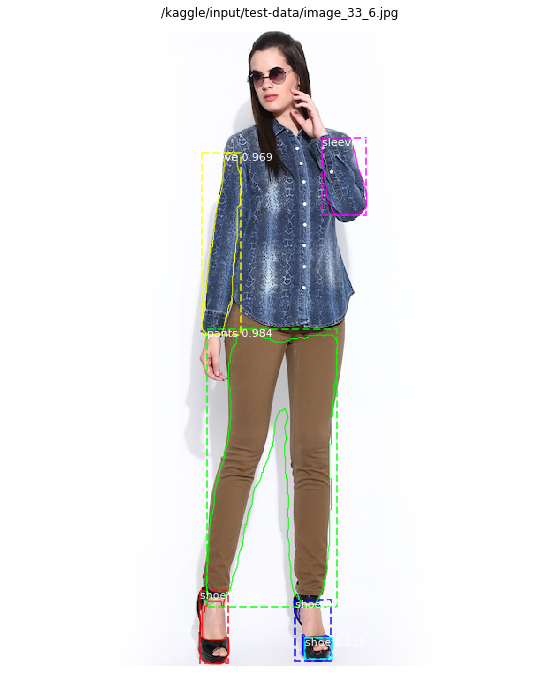

In [ ]:
visualize.display_instances(img, rois, masks, r['class_ids'], 
                            ['bg']+label_names, r['scores'],
                            title=path, figsize=(12, 12),show_mask=False)

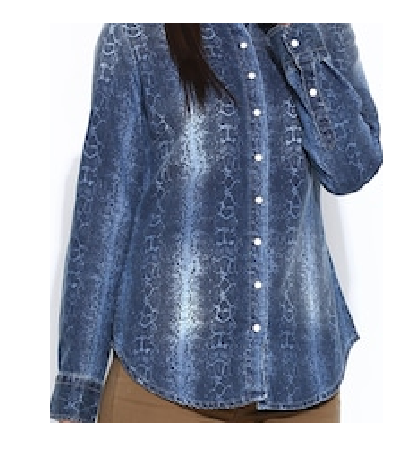

In [ ]:
#crop samples that we will pass to embedding module for searching samples
for i in upperbody_images:
  outimage = i
  _, ax = plt.subplots(1, figsize=(8,8))
  auto_show = True

  height, width = outimage.shape[:2]
  ax.set_ylim(height + 10, -10)
  ax.set_xlim(-10, width + 10)
  ax.axis('off')
  img1 = outimage.astype(np.uint32).copy()
  ax.imshow(img1.astype(np.uint8))
  plt.show()

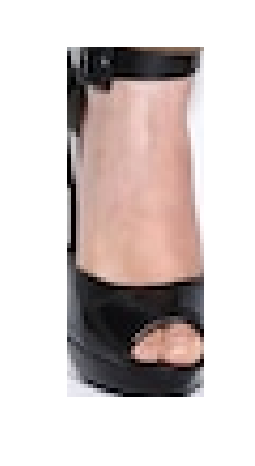

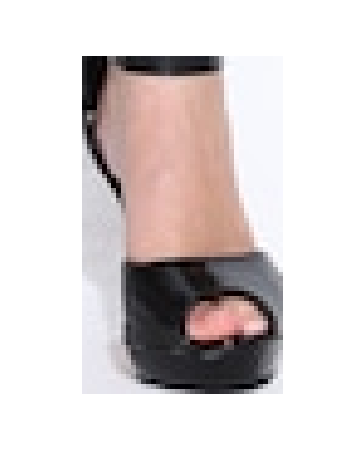

In [ ]:
for i in range(1):
  outimage = feet_images[i]
  _, ax = plt.subplots(1, figsize=(8,8))
  auto_show = True

  height, width = outimage.shape[:2]
  ax.set_ylim(height + 10, -10)
  ax.set_xlim(-10, width + 10)
  ax.axis('off')
  img1 = outimage.astype(np.uint32).copy()
  ax.imshow(img1.astype(np.uint8))
  plt.show()

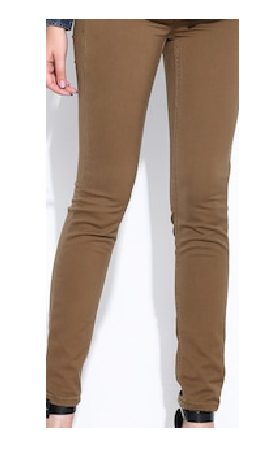

In [ ]:
for i in lowerbody_images:
  outimage = i
  _, ax = plt.subplots(1, figsize=(8,8))
  auto_show = True

  height, width = outimage.shape[:2]
  ax.set_ylim(height + 10, -10)
  ax.set_xlim(-10, width + 10)
  ax.axis('off')
  img1 = outimage.astype(np.uint32).copy()
  ax.imshow(img1.astype(np.uint8))
  plt.show()